In [1]:
# === Auto-reload setup for development ===
# === Development setup ===
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath("."))

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

# Add backend folder to Python path
sys.path.append(os.path.join(os.getcwd(), "backend"))

from config_loader import load_config, get_corr_matrices, get_solvency_params, get_etf_universe
from optimization import solve_frontier_combined
from solvency_calc import scr_interest_rate, scr_eq, scr_prop, scr_sprd, aggregate_market_scr, marginal_scr, allocate_marginal_scr
from data_handler import expected_return_yf, get_ecb_yield, get_interpolated_ecb_yield, load_eiopa_excel
from data_handler import spread_shock, interpolate_shocks
from helpers import summarize_portfolio, plot_frontier


In [3]:
# Sample data

# Liabilities
liab_value = 1424.2
liab_duration = 6.6

# Assets
asset_list = ['gov_bond', 'corp_bond', 'equity_1', 'equity_2', 'property', 't_bills']
initial_asset = pd.DataFrame(index=asset_list)
initial_asset['asset_val'] = [830, 586, 0, 102.5, 42, 139.6]
initial_asset['asset_dur'] = [5.2, 5.0, 0.0, 0.0, 0.0, 0.1]


In [4]:
# Import config params

config = load_config()
corr_downward, corr_upward = get_corr_matrices(config)
hard_params = get_solvency_params(config)
etfs = get_etf_universe(config)

In [5]:
# Get expected return for the corp bond, equity (1-2), property

etf_returns = {}

for _, row in etfs.iterrows():
    ticker = row["ticker"]
    key = row["key"]
    print(f"Fetching {key} ({ticker})...")
    etf_returns[key] = expected_return_yf(
        ticker,
        trading_days=252,
        period='1y'
    )

Fetching corp_bond (IE15.L)...
Fetching property (EUNK.DE)...
Fetching equity_2 (IQQE.DE)...
Fetching equity_1 (EUNL.DE)...


In [6]:
# Fetch current government bond return from ECB
gov_bond_mat = initial_asset['asset_dur'].iloc[0]
gov_bond_ret = get_interpolated_ecb_yield(gov_bond_mat)

# Fetch current t-bills return from ECB
t_bill_mat = initial_asset['asset_dur'].iloc[5]
t_bill_ret = get_interpolated_ecb_yield(t_bill_mat)

# Asset return vector
expected_return = [gov_bond_ret, 
                   etf_returns['corp_bond'],
                   etf_returns['equity_1'],
                   etf_returns['equity_2'],
                   etf_returns['property'],
                   t_bill_ret]

initial_asset['asset_ret'] = expected_return
initial_asset['asset_weight'] = initial_asset['asset_val']/initial_asset['asset_val'].sum()

Interpolating between 5Y (5.0Y) and 7Y (7.0Y)...
Latest date: 2025-11-10, Interpolated 5.20Y yield = 2.269%
Maturity 0.1Y below 0.25Y — using 0.25Y instead.


In [7]:
### TABLE TO SHOW
initial_asset

,asset_val,asset_dur,asset_ret,asset_weight
gov_bond,830.0,5.2,0.022688,0.488207
corp_bond,586.0,5.0,0.034709,0.344686
equity_1,0.0,0.0,0.087455,0.000000
equity_2,102.5,0.0,0.187858,0.060291
property,42.0,0.0,0.162400,0.024704
t_bills,139.6,0.1,0.019247,0.082113


In [14]:
# Calculate interest shock & spread shock 

# Interest shock
port_duration = initial_asset['asset_dur'] @ initial_asset['asset_weight']
eiopa_curve = load_eiopa_excel()
int_up_shock, int_down_shock = interpolate_shocks(eiopa_curve, port_duration)

# Spread shock 
corp_bond_dur = initial_asset['asset_dur'].iloc[1]
sprd_shock = spread_shock(corp_bond_dur)

### CALCULATE SCR

In [9]:
scr_interest = scr_interest_rate(
    initial_asset['asset_val'], 
    initial_asset['asset_dur'], 
    liab_value, 
    liab_duration, 
    int_up_shock, 
    int_down_shock
)

scr_equity = scr_eq(
    initial_asset['asset_val'].iloc[2],
    initial_asset['asset_val'].iloc[3],
    hard_params['equity_1_param'],
    hard_params['equity_2_param'],
    hard_params['rho']
)

scr_property = scr_prop(
    initial_asset['asset_val'].iloc[4],
    hard_params['prop_params']
)

scr_spread = scr_sprd(
    initial_asset['asset_val'].iloc[1],
    sprd_shock
)

market_scr = aggregate_market_scr(
    scr_interest,
    scr_equity, 
    scr_property,
    scr_spread,
    corr_downward,
    corr_upward
)

market_scr['summary_table']

,SCR
risk,
interest,73.980196
equity,50.225000
property,10.500000
spread,87.900000
total,187.519990
diversification,35.085206


In [10]:
# Create the SCR vector
scr_vec = np.array([
    scr_interest["SCR_interest"],
    scr_equity["SCR_eq_total"],
    scr_property,
    scr_spread
])

# Compute marginal SCR by risk type
marginal_df = marginal_scr(
    v=scr_vec,
    direction=market_scr["chosen_panel"],
    corr_downward=corr_downward,
    corr_upward=corr_upward
)

marginal_df


,risk,SCR,marginal_factor,allocated_SCR,share_%
0,interest,73.980196,0.475873,35.205187,22.645522
1,equity,50.225000,0.797783,40.068665,25.773925
2,property,10.500000,0.592548,6.221757,4.002107
3,spread,87.900000,0.841484,73.966413,47.578446


In [11]:
# Calculate margin SCR by asset

params = {
    "interest_down":    int_down_shock,
    "interest_up":      int_up_shock,
    "spread":           sprd_shock,
    "equity_type1":     hard_params['equity_1_param'],
    "equity_type2":     hard_params['equity_2_param'],
    "property":         hard_params['prop_params'],
    "rho":              hard_params['rho']
}

asset_mSCR = allocate_marginal_scr(
    marginal_df,
    market_scr["chosen_panel"],
    initial_asset,
    params
)

asset_mSCR

,asset,mSCR
0,gov_bond,-0.027703
1,corp_bond,0.099585
2,equity_1,0.233352
3,equity_2,0.390914
4,property,0.148137
5,t_bills,-0.000533


### OPTMIZATION

In [12]:
allocation_limits_data = {
    "asset": [
        "gov_bond",
        "illiquid_assets",
        "t_bills",
        "corp_bond",
    ],
    "description": [
        "Government Bonds",
        "Equities + Property (Illiquid)",
        "Treasury Bills",
        "Corporate Bonds",
    ],
    "min_weight": [
        0.25,   # gov min
        0.0,    # illiquid min
        0.01,   # t-bills min
        0.0,    # corp min
    ],
    "max_weight": [
        0.75,   # gov max
        0.20,   # illiquid max
        0.05,   # t-bills max
        0.50,   # corp max (as in the paper)
    ]
}

allocation_limits = pd.DataFrame(allocation_limits_data).set_index("asset")

allocation_limits


,description,min_weight,max_weight
asset,,,
gov_bond,Government Bonds,0.25,0.75
illiquid_assets,Equities + Property (Illiquid),0.00,0.20
t_bills,Treasury Bills,0.01,0.05
corp_bond,Corporate Bonds,0.00,0.50


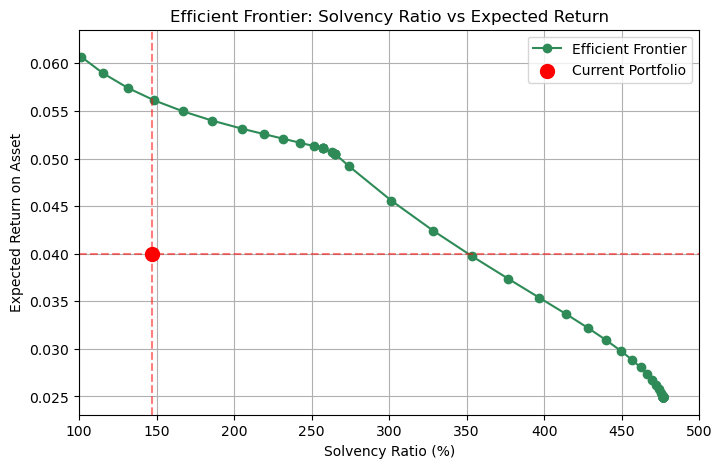

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Efficient Frontier: Solvency Ratio vs Expected Return'}, xlabel='Solvency Ratio (%)', ylabel='Expected Return on Asset'>)

In [13]:
opt_result = solve_frontier_combined(
    initial_asset, 
    liab_value,
    liab_duration,
    corr_downward,
    corr_upward, 
    allocation_limits, 
    params
)

# Current solvency ratio 
current_sol = (initial_asset['asset_val'].sum() - liab_value) / market_scr['SCR_market_final']

# Expected return
current_ret = (initial_asset['asset_ret'] @ initial_asset['asset_weight'])

plot_frontier(
    opt_result,
    current_sol,
    current_ret,
    min_sol_pct=90,
    title='Efficient Frontier: Solvency Ratio vs Expected Return',
    show=True
)
